In [1]:
!pip install deap

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.color import rgb2gray
from skimage.filters import gabor
from skimage.measure import moments_hu, find_contours
from deap import base, creator, tools, algorithms
from sklearn.metrics.pairwise import cosine_similarity
import random
import warnings
warnings.filterwarnings("ignore")


**Load Images and Labels**

In [4]:
def load_uc_merced_images(dataset_path, img_size=(128, 128), max_per_class=100):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))

    for cls in class_names:
        class_dir = os.path.join(dataset_path, cls)
        img_files = sorted(os.listdir(class_dir))[:max_per_class]
        for file in img_files:
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(cls)

    return np.array(images), np.array(labels)

dataset_path = "/kaggle/input/image-retrivel/UCMerced_LandUse/Images"
images, labels = load_uc_merced_images(dataset_path)
print(f"✅ Loaded {len(images)} images with shape {images[0].shape}")


✅ Loaded 2100 images with shape (128, 128, 3)


**Feature Extraction Functions**

In [5]:
def extract_color_features(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()

    # Color moments
    mean, std, skew = cv2.meanStdDev(hsv)
    return np.concatenate([hist, mean.flatten(), std.flatten()])

def extract_texture_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, [1], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]

    # LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max()+3), range=(0, lbp.max()+2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    # Gabor
    _, gabor_img = gabor(gray, frequency=0.6)
    gabor_mean = np.mean(gabor_img)
    gabor_var = np.var(gabor_img)

    return np.concatenate([[contrast, homogeneity, energy], hist, [gabor_mean, gabor_var]])

def extract_shape_features(img):
    gray = rgb2gray(img)
    contours = find_contours(gray, 0.8)
    if len(contours) == 0:
        hu = np.zeros(7)
    else:
        cnt = max(contours, key=len)
        hu = moments_hu(np.array(cnt))
    return hu

def extract_hybrid_features(img):
    color = extract_color_features(img)
    texture = extract_texture_features(img)
    shape = extract_shape_features(img)
    return np.concatenate([color, texture, shape])


In [11]:
print(f"Total images loaded: {len(images)}")
print(f"Image shape example: {images[0].shape if len(images) > 0 else 'No images'}")

Total images loaded: 2100
Image shape example: (128, 128, 3)


**Normalize Feature Matrix**

In [14]:
def extract_shape_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros(7)  # Return 0 vector if no contour found
    
    # Use the largest contour
    cnt = max(contours, key=cv2.contourArea)
    
    # Calculate Hu Moments (7 invariant moments)
    hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
    
    return hu_moments


In [15]:
def extract_hybrid_features(img):
    color = extract_color_features(img)
    texture = extract_texture_features(img)
    shape = extract_shape_features(img)
    return np.concatenate([color, texture, shape])

In [16]:
features = []
for i, img in enumerate(images):
    try:
        f = extract_hybrid_features(img)
        features.append(f)
    except Exception as e:
        print(f" Error in image {i}: {e}")

features = np.array(features)
print(f"✅ Total successful feature vectors: {features.shape}")


✅ Total successful feature vectors: (2100, 544)


In [17]:
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
print("📐 Normalized feature shape:", features_normalized.shape)

📐 Normalized feature shape: (2100, 544)


**Genetic Algorithm for Feature Optimization**

**Run the Optimization**

In [19]:
selected_mask, best_score = run_genetic_algorithm(features_normalized, labels, n_gen=10, pop_size=30)

print(f" Best MAP@5 score: {best_score:.4f}")
print(f" Selected {np.sum(selected_mask)} / {features_normalized.shape[1]} features.")


gen	nevals	avg     	max     
0  	30    	0.617787	0.645905
1  	23    	0.631305	0.64619 
2  	10    	0.637978	0.64619 
3  	23    	0.643324	0.652286
4  	16    	0.646895	0.652667
5  	18    	0.64927 	0.653238
6  	20    	0.650225	0.655905
7  	21    	0.652038	0.656286
8  	18    	0.65501 	0.658667
9  	20    	0.655768	0.659048
10 	12    	0.657549	0.660762
✅ Best MAP@5 score: 0.6608
🎯 Selected 281 / 544 features.


**Run Retrieval with GA-Optimized Features:**

In [23]:
import os
from glob import glob

DATASET_PATH = "/kaggle/input/image-retrivel/UCMerced_LandUse/Images"
categories = sorted(os.listdir(DATASET_PATH))

images = []
labels = []
image_paths = []  

for label in categories:
    folder_path = os.path.join(DATASET_PATH, label)
    for file in glob(os.path.join(folder_path, "*.tif")):
        img = cv2.imread(file)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)
            image_paths.append(file) 

In [25]:
import matplotlib.pyplot as plt

def show_retrieved_images(query_index, retrieved_indices, image_paths):
    plt.figure(figsize=(15, 3))
    
    # Show query image
    plt.subplot(1, len(retrieved_indices)+1, 1)
    query_img = cv2.cvtColor(cv2.imread(image_paths[query_index]), cv2.COLOR_BGR2RGB)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis('off')

    # Show retrieved images
    for i, idx in enumerate(retrieved_indices):
        plt.subplot(1, len(retrieved_indices)+1, i+2)
        img = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Top {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

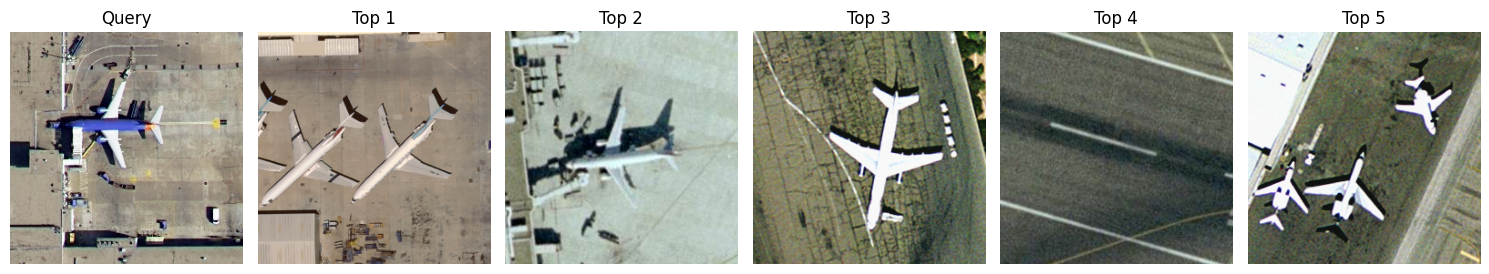

In [32]:
query_index = 100
retrieved_indices = retrieve_similar_images(query_index, ga_selected_features, image_paths, top_k=5)
show_retrieved_images(query_index, retrieved_indices, image_paths)

In [41]:
print(" Extracting hybrid features...")
features = [extract_hybrid_features(img) for img in tqdm(images)]
features = np.array([f for f in features if f.shape[0] > 1])  # Filter out failed ones
labels = labels[:features.shape[0]]
print(f" Feature matrix shape: {features.shape}")


 Extracting hybrid features...


100%|██████████| 2100/2100 [00:31<00:00, 66.05it/s]


 Feature matrix shape: (2100, 544)


In [42]:
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

In [53]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

In [54]:
from sklearn.preprocessing import label_binarize
unique_labels = np.unique(labels)
label_dict = {label: idx for idx, label in enumerate(unique_labels)}
labels_encoded = np.array([label_dict[l] for l in labels])
labels_onehot = label_binarize(labels_encoded, classes=range(len(unique_labels)))

In [55]:
NUM_FEATURES = features_normalized.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=NUM_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_genetic(individual):
    mask = np.array(individual, dtype=bool)
    if not any(mask):
        return 0.0,
    X_selected = features_normalized[:, mask]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, labels_encoded, test_size=0.3, stratify=labels_encoded)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred),

toolbox.register("evaluate", eval_genetic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=20)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

best_ind = tools.selBest(pop, k=1)[0]
selected_mask = np.array(best_ind, dtype=bool)
ga_selected_features = features_normalized[:, selected_mask]
print(f" GA selected {selected_mask.sum()} features.")

gen	nevals
0  	20    
1  	10    
2  	9     
3  	6     
4  	10    
5  	13    
6  	13    
7  	16    
8  	13    
9  	11    
10 	16    
 GA selected 279 features.


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    ga_selected_features, labels_encoded, test_size=0.3, stratify=labels_encoded
)

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" Precision:", precision_score(y_test, y_pred, average='macro'))
print(" Recall:", recall_score(y_test, y_pred, average='macro'))
print(" F1 Score:", f1_score(y_test, y_pred, average='macro'))
print(" ROC AUC Score:", roc_auc_score(label_binarize(y_test, classes=range(len(unique_labels))), y_proba, average='macro', multi_class='ovr'))


 Accuracy: 0.719047619047619
 Precision: 0.73073398597634
 Recall: 0.719047619047619
 F1 Score: 0.7150184848049419
 ROC AUC Score: 0.9334285714285713


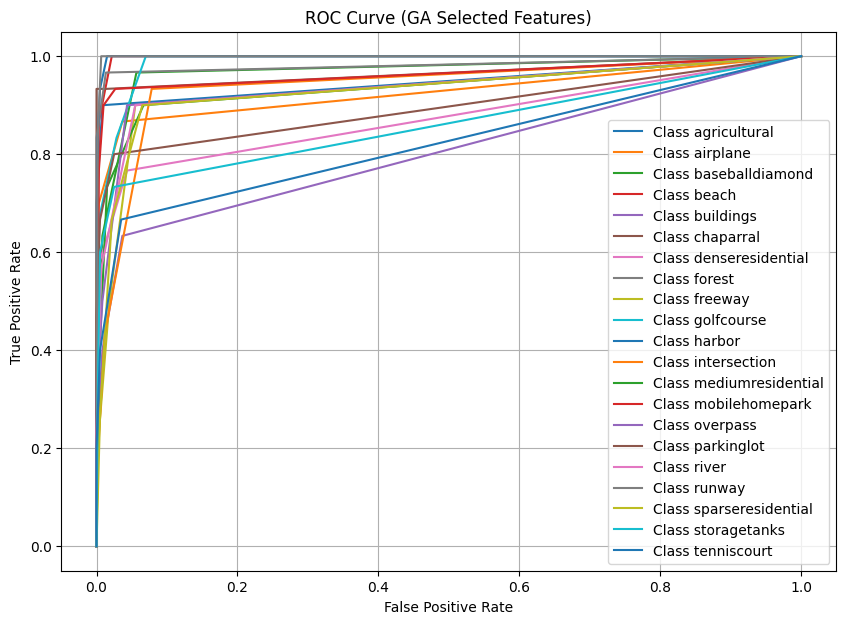

In [57]:
plt.figure(figsize=(10, 7))
for i in range(len(unique_labels)):
    fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=range(len(unique_labels)))[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {unique_labels[i]}")

plt.title("ROC Curve (GA Selected Features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()